# Predict Housing Prices Using a Simple Linear Regression Model

## Installing kaggle library

In [ ]:
!pip install kaggle

## Reading kaggle username and key and Keep them in Environment Variables

In [ ]:
import json
import os

# Upload kaggle.json to the same directory as your notebook
with open('kaggle.json') as f:
    kaggle_token = json.load(f)

os.environ['KAGGLE_USERNAME'] = kaggle_token['username']
os.environ['KAGGLE_KEY'] = kaggle_token['key']


## Downloading the boston house prices datatset from Kaggle using the Username and key

In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

## Extracting the boston house prices dataset

In [ ]:
import zipfile

with zipfile.ZipFile('house-prices-advanced-regression-techniques.zip', 'r') as zip_ref:
    zip_ref.extractall('boston_housing_dataset')

## Importing the libraries 

In [784]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Importing the dataset

In [785]:
df = pd.read_csv('./boston_housing_dataset/train.csv')

## Preprocessing Data

In [786]:
# filling NaN data mapping
na_mapping = {
    'None_Alley': ['Alley'],
    'Veneer': ['MasVnrType'],
    'NE': ['Electrical'],
    'NF': ['FireplaceQu', 'Fence', 'MiscFeature'],
    'NP': ['PoolQC'],
    'NB': ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical'],
    'NG': ['GarageType', 'GarageQual', 'GarageCond', 'GarageFinish'],
    0: ['GarageYrBlt']
}
# dropping MasVnrArea rows which have NaN value. There are about 8 rows < 1%
df.dropna(axis=0, subset=['MasVnrArea'], inplace=True)

# Filling NaN data with mean value
df['LotFrontage'] = df.groupby('MSZoning')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))

# Filling NaN data based on the mapping dictionary
for value, columns in na_mapping.items():
    df[columns] = df[columns].apply(lambda x: x.fillna(value))

## Encoding Ordinal Categories Data

In [787]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

# Define the order for each ordinal feature
categories = [
    # PoolQC 
    ['NP', 'Fa', 'TA', 'Gd', 'Ex'],
    # GarageCond
    ['NG', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    # GarageQual
    ['NG', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    # FireplaceQu
    ['NF', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    # KitchenQual
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    # HeatingQC
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    # ExterCond
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    # ExterQual
    ['Po', 'Fa', 'TA', 'Gd', 'Ex']  
]
columns = ['PoolQC', 'GarageCond', 'GarageQual', 'FireplaceQu', 'KitchenQual', 'HeatingQC', 'ExterCond', 'ExterQual']

# Initialize the OrdinalEncoder with the specified orders
encoder = OrdinalEncoder(categories=categories)

# Fit and transform the data
df[columns] = encoder.fit_transform(df[columns])

## Encoding Nominal Categories Data

In [788]:
columns = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 
           'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 
           'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
           'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtQual', 'BsmtCond', 
           'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir',
           'Electrical', 'Functional', 'GarageType', 'GarageFinish', 
           'PavedDrive','Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
df = pd.get_dummies(df, columns=columns, dtype='int')

## Processing Skewness Data

Some feautures in the dataset are skewed so applying np.log or np.sqrt
to try to reduce the skewness and hoping impoving the performance of the
model. Below cell is an visualization of skewness of SalePrice and appying
np.log 

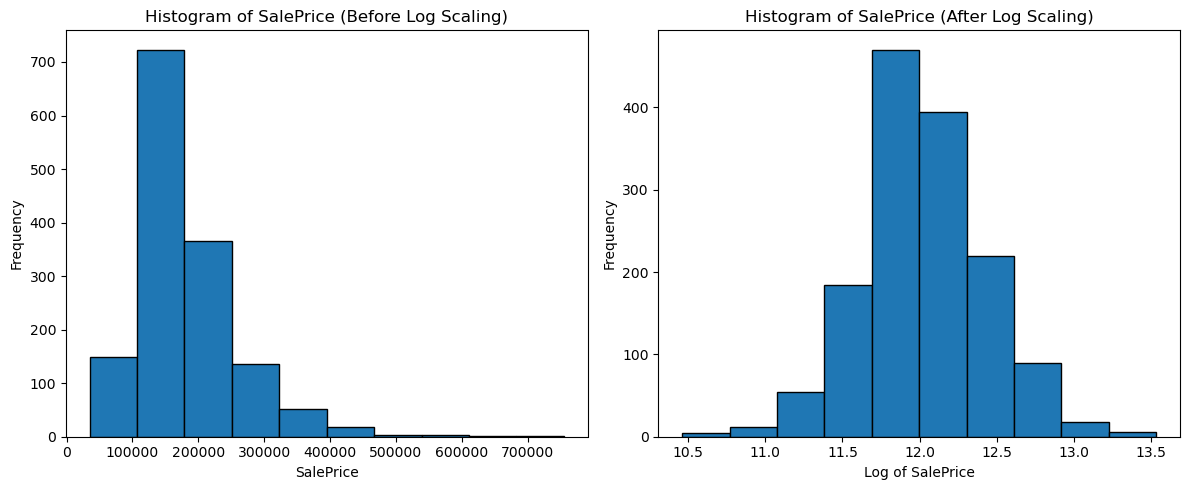

In [789]:
import matplotlib.pyplot as plt

# Create histogram before log scaling
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(x=df['SalePrice'], bins=10, edgecolor='black')
plt.title('Histogram of SalePrice (Before Log Scaling)')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')

# Apply log transformation
log_df = np.log(df['SalePrice'])

# Create histogram after log scaling
plt.subplot(1, 2, 2)
plt.hist(x=log_df, bins=10, edgecolor='black')
plt.title('Histogram of SalePrice (After Log Scaling)')
plt.xlabel('Log of SalePrice')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

In [790]:
# a list of columns are going to be applied np.log
log_columns = ['LotArea', '1stFlrSF', 'GrLivArea', 'LotFrontage']

# a list of columns are going to be applied np.sqrt
sqrt_columns = ['MasVnrArea', 'BsmtUnfSF', 'BsmtFinSF1', '2ndFlrSF', 
                'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', '3SsnPorch']

# applying np.log to the dataset
for log_column in log_columns:
    df[log_column] = np.log(df[log_column])
    
# applying np.sqlt to the dataset
for sqrt_column in sqrt_columns:
    df[sqrt_column] = np.sqrt(df[sqrt_column])

## Splitting the dataset into the Training set and Test set

In [791]:
from sklearn.model_selection import train_test_split

drop_columns = ['Id', 'SalePrice', 'ScreenPorch',  'EnclosedPorch',
               'BsmtFinSF2']

y = df['SalePrice'].values
X = df.drop(columns=drop_columns).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# fix skewness on the Target feature
y_train = np.log(y_train)

## Feature Scaling
Performing feature scaling on MSSubClass feature

In [792]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
X_train[:, 0:1] = scaler.fit_transform(X_train[:, 0:1])
X_test[:, 0:1] = scaler.transform(X_test[:, 0:1])

## Perfoming Cross validation to check the everage accuracy of the model with the dataset

In [793]:
from sklearn.model_selection import cross_val_score

accuracies = cross_val_score(estimator = LinearRegression(), X = X_train, y = y_train, cv = 5)
print("Cross-validation scores:", accuracies)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Cross-validation scores: [0.91 0.73 0.8  0.91 0.88]
Accuracy: 84.82 %
Standard Deviation: 6.99 %


## Training the LinearRegression model on the Training set

In [794]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

## Model Evaluation

In [795]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_log = regressor.predict(X_test)
y_pred = np.exp(y_pred_log)
# Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Output the evaluation metrics in a readable format
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Mean Absolute Error (MAE): 15662.02
Root Mean Squared Error (RMSE): 26645.00
R-squared (R²): 0.89


## Prediction

In [796]:
y_pred_log = regressor.predict(X_test[1: 5, :])
y_pred = np.exp(y_pred_log)
y_test_selected = y_test[1: 5]
data = {"Predicted Price": y_pred, "Price": y_test_selected}
data_df = pd.DataFrame(data)
data_df

,Predicted Price,Price
0,150658.763217,164000
1,229052.811259,225000
2,137070.121248,241500
3,214404.523868,192000


# Summary:

#### The R-squared (R²): 0.89 
means that the dataset fixing with the model well.

#### Mean Absolute Error (MAE): 15816.61 
means the predicted house price might be approximately between:
house price = [predicted house price] − 15,816.61
and
house price = [predicted house price] + 15,816.61

#### Root Mean Squared Error (RMSE)
means

Percentage RMSE= (RMSE*100)/Average_house_price = 14.84%, the errors model’s predictions are about 14.84%